In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Introduction

In [2]:
DATA = Path('../input/anadolu-hayat-emeklilik-datathon-coderspace')

df_train = pd.read_csv(DATA / 'train.csv')
df_test = pd.read_csv(DATA / 'test.csv', low_memory=False)

print(f'Training Set Shape: {df_train.shape} - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape: {df_test.shape} - Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (634112, 49) - Memory Usage: 237.06 MB
Test Set Shape: (243137, 48) - Memory Usage: 89.04 MB


## 2. Preprocessing

In [3]:
df_train.loc[df_train['SOZLESME_KOKENI'] == 'TRANS', 'SOZLESME_KOKENI'] = 'TRANS_C'
# Replace comma with dots for float conversion
df_train['GELIR'] = df_train['GELIR'].str.replace(',', '.').astype(np.float32)
df_test['GELIR'] = df_test['GELIR'].str.replace(',', '.').astype(np.float32)
# Few negative values in GELIR are replaced with zero
df_train.loc[df_train['GELIR'] < 0, 'GELIR'] = 0
df_test.loc[df_test['GELIR'] < 0, 'GELIR'] = 0

positive_continous_features = [
    'GELIR',
    'OCAK_ODENEN_TUTAR', 'OCAK_VADE_TUTARI', 'SUBAT_ODENEN_TU', 'SUBAT_VADE_TUTARI',
    'MART_ODENEN_TUTAR', 'MART_VADE_TUTARI', 'NISAN_ODENEN_TUTAR', 'NISAN_VADE_TUTARI',
    'MAYIS_ODENEN_TUTAR', 'MAYIS_VADE_TUTARI', 'HAZIRAN_ODENEN_TUTAR', 'HAZIRAN_VADE_TUTARI',
    'TEMMUZ_ODENEN_TUTAR', 'TEMMUZ_VADE_TUTARI', 'AGUSTOS_ODENEN_TUTAR', 'AGUSTOS_VADE_TUTARI',
    'EYLUL_ODENEN_TUTAR', 'EYLUL_VADE_TUTARI', 'EKIM_ODENEN_TUTAR', 'EKIM_VADE_TUTARI',
    'KASIM_ODENEN_TUTAR', 'KASIM_VADE_TUTARI', 'ARALIK_ODENEN_TUTAR', 'ARALIK_VADE_TUTARI'
]
# Log transform positive continuous features in order to deal with extreme skewness
# Using log1p operation since vanilla log transforms zeros to -infinite
for df in [df_train, df_test]:
    for continous_feature in positive_continous_features:
        df[continous_feature] = np.log1p(df[continous_feature])

positive_and_negative_continuous_features = ['SENE_BASI_HESAP_DEGERI', 'SENE_SONU_HESAP_DEGERI']
# Continuous features with both positive and negative values are standardized
# This makes the continuous features on different scales but that doesn't affect tree-based models
for df in [df_train, df_test]:
    for continous_feature in positive_and_negative_continuous_features:
        smallest_negative_value = pd.concat((
            df_train[continous_feature],
            df_test[continous_feature]
        ), axis=0, ignore_index=True).min()
        df[continous_feature] = np.log1p(df[continous_feature] + 1 - smallest_negative_value)

## 3. Target

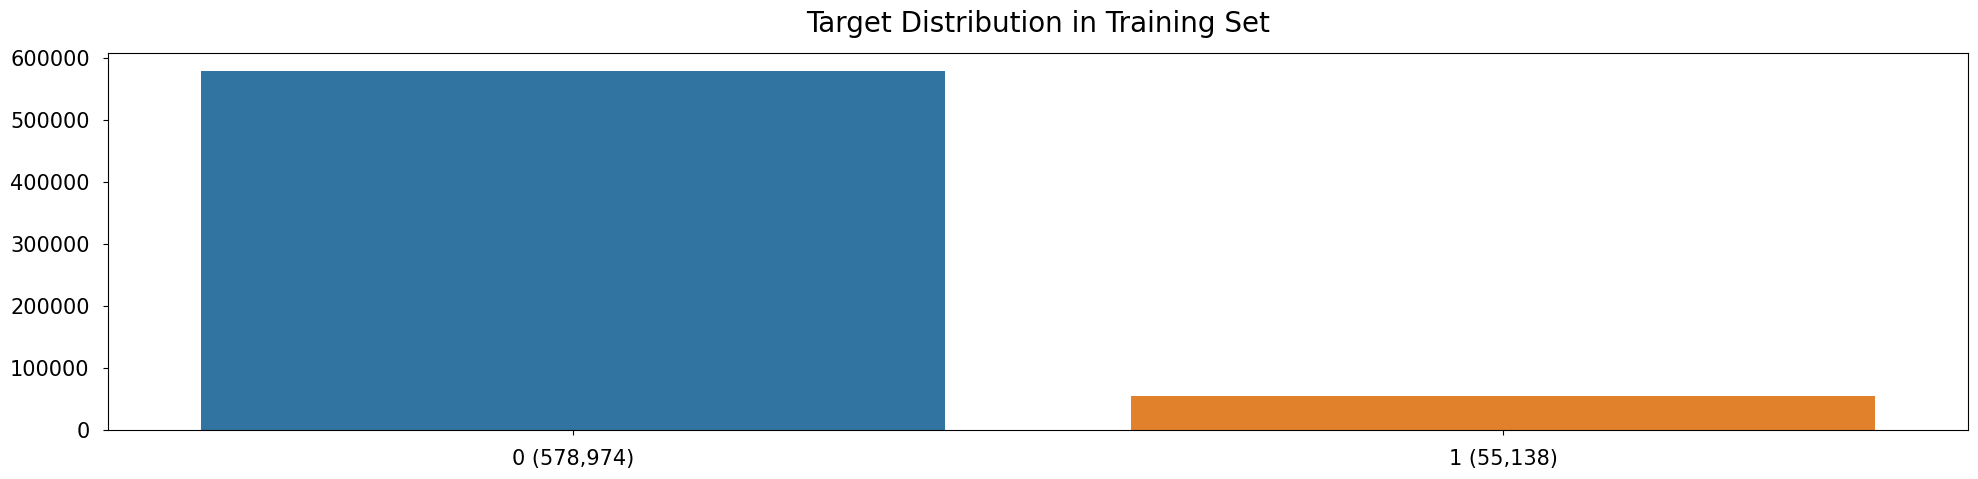

In [4]:
def visualize_target(df_train):
    
    fig, ax = plt.subplots(figsize=(24, 5), dpi=100)

    sns.barplot(
        x=df_train['ARTIS_DURUMU'].value_counts().index,
        y=df_train['ARTIS_DURUMU'].value_counts().values,
        ax=ax
    )

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([f'{x} ({value_count:,})' for value_count, x in zip(df_train['ARTIS_DURUMU'].value_counts().values, df_train['ARTIS_DURUMU'].value_counts().index)])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title('Target Distribution in Training Set', size=20, pad=15)

    plt.show()


visualize_target(df_train)

## 4. Continuous Features

In [5]:
def visualize_continuous_feature(df_train, df_test, column):
    
    print(f'{column}\n{"-" * len(column)}')
    for dataset, df in zip(['Training', 'Test'], [df_train, df_test]):
        print(f'\n{dataset}\n{"-" * len(dataset)}')
        print(f'Mean: {df[column].mean():.4f}  -  Median: {df[column].median():.4f}  -  Std: {df[column].std():.4f}')
        print(f'Min: {df[column].min():.4f}  -  25%: {df[column].quantile(0.25):.4f}  -  50%: {df[column].quantile(0.5):.4f}  -  75%: {df[column].quantile(0.75):.4f}  -  Max: {df[column].max():.4f}')
        print(f'Skew: {df[column].skew():.4f}  -  Kurtosis: {df[column].kurtosis():.4f}')
        missing_count = df[df[column].isnull()].shape[0]
        total_count = df.shape[0]
        print(f'Missing Values: {missing_count}/{total_count} ({missing_count * 100 / total_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 6), dpi=100)
    
    sns.kdeplot(df_train.loc[df_train['ARTIS_DURUMU'] == 0, column], label='Negative', fill=True, ax=axes[0])
    sns.kdeplot(df_train.loc[df_train['ARTIS_DURUMU'] == 1, column], label='Positive', fill=True, ax=axes[0])
    axes[0].axvline(df_train.loc[df_train['ARTIS_DURUMU'] == 0, column].mean(), label='Negative Mean', color='r', linewidth=2, linestyle='--')
    axes[0].axvline(df_train.loc[df_train['ARTIS_DURUMU'] == 0, column].median(), label='Negative Median', color='b', linewidth=2, linestyle='--')
    axes[0].axvline(df_train.loc[df_train['ARTIS_DURUMU'] == 1, column].mean(), label='Positive Mean', color='g', linewidth=2, linestyle='--')
    axes[0].axvline(df_train.loc[df_train['ARTIS_DURUMU'] == 1, column].median(), label='Positive Median', color='y', linewidth=2, linestyle='--')
    axes[0].legend(prop={'size': 15})

    sns.kdeplot(df_train[column], label='Training', fill=True, ax=axes[1])
    sns.kdeplot(df_test[column], label='Test', fill=True, ax=axes[1])
    axes[1].axvline(df_train[column].mean(), label='Training Mean', color='r', linewidth=2, linestyle='--')
    axes[1].axvline(df_train[column].median(), label='Training Median', color='b', linewidth=2, linestyle='--')
    axes[1].axvline(df_test[column].mean(), label='Test Mean', color='g', linewidth=2, linestyle='--')
    axes[1].axvline(df_test[column].median(), label='Test Median', color='y', linewidth=2, linestyle='--')
    axes[1].legend(prop={'size': 15})
    
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=12.5)
        axes[i].tick_params(axis='y', labelsize=12.5)
        axes[i].set_ylabel('')
    axes[0].set_xlabel('')
    axes[1].set_xlabel('Time', fontsize=12.5)
    axes[0].set_title(f'{column} Distribution in Classes', fontsize=15, pad=12)
    axes[1].set_title(f'{column} Distribution in Datasets', fontsize=15, pad=12)
    
    plt.show()


for continuous_feature in continuous_features:
    visualize_continuous_feature(df_train, df_test, continuous_feature)

NameError: name 'continuous_features' is not defined

In [ ]:
def visualize_correlations(df, features):

    fig = plt.figure(figsize=(16, 16), dpi=100)
    sns.heatmap(
        df[features].corr(),
        annot=True,
        square=True,
        cmap='coolwarm',
        annot_kws={'size': 10},
        fmt='.2f'
    )

    plt.tick_params(axis='x', labelsize=12.5, rotation=90)
    plt.tick_params(axis='y', labelsize=12.5, rotation=0)
    plt.title('Correlations', size=20, pad=20)

    plt.show()


visualize_correlations(df_train, continuous_features)
visualize_correlations(df_test, continuous_features)